In [75]:
import pandas as pd
import numpy as np



# from scipy.stats import spearmanr, rankdata
# from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler




In [76]:
def load_data(path):

    files = os.listdir(f'{path}\\img\\data\\')
    image = np.empty((len(files), 50, 50, 1))
    sample = []
    id = []
    for i in range(len(files)):
        if files[i].split('.')[1] == 'txt':
            id.append(i)
            data = pd.read_csv(f'{path}\\img\\data\\{files[i]}', sep='\t', engine='c', na_values=['na', '-', ''], header=None, index_col=None)
            image[i, :, :, 0] = data.values
            sample.append(files[i].split('.txt')[0])
    image = image[id, :, :, :]

    return image

In [10]:
# def train_test_data(data_main, test_per = 0.2):
#     rand_test_index= np.random.randint(0, data_main.shape[0], np.int64(data_main.shape[0]*test_per))
#     test_data = data_main[rand_test_index]
#     train_data = np.delete(data_main, rand_test_index, axis = 0)

#     return train_data, test_data, rand_test_index


# train_data, test_data, test_indx = train_test_data(all_data, test_per=0.1)

In [77]:
# data_path = '..\\Results\\Table_To_Image_Conversion\\Test_1\\data'
data_path = "D:\\Research\\data\\processed_dataset" #lab

tissue_type = 'liver'
# tissue_type = 'pancreas'
# tissue_type = 'kidney'



all_data = load_data(path = f'{data_path}\\{tissue_type}')
all_data.shape

(981, 50, 50, 1)

In [78]:
all_data = all_data/255

In [79]:
y_target = pd.read_csv(f'{data_path}\\{tissue_type}\\miRNA_bulk.csv')
y_target = y_target.drop('Unnamed: 0',axis=1)

y_target = y_target.iloc[:,1:].drop(y_target.index[(y_target.iloc[:,1:].sum(axis = 1) < 90)]).T


y_target.shape

# y_target = y_target.iloc[:,1:].T
# y_target = y_target.values
# y_target

(981, 26)

In [80]:
from sklearn import preprocessing

y_target = preprocessing.normalize(y_target)
y_target


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.31622777, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [81]:
X_train, X_test, y_train, y_test = train_test_split(all_data, y_target, test_size=0.1, random_state=1)

print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')




X_train: (882, 50, 50, 1)
X_test: (99, 50, 50, 1)
y_train: (882, 26)
y_test: (99, 26)


(784, 50, 50)

In [82]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the model
model = keras.Sequential()

# Add the layers to the model
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(50, 50, 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())

# Flatten the output before passing it to the fully connected layers
model.add(layers.Flatten())

# Add fully connected layers
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(26, activation='softmax'))

# Compile the model
model.compile(optimizer='Adam',
              loss='mse',
              metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_66 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_57 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_67 (Conv2D)          (None, 22, 22, 32)        18464     
                                                                 
 batch_normalization_58 (Bat  (None, 22, 22, 32)       128       
 chNormalization)                                                
                                                     

In [83]:
history = model.fit(X_train, y_train, epochs=300, batch_size=32)

Epoch 1/300
28/28 [==============================] - 1s 18ms/step - loss: 0.0230 - accuracy: 0.1667
Epoch 2/300
28/28 [==============================] - 0s 15ms/step - loss: 0.0209 - accuracy: 0.2256
Epoch 3/300
28/28 [==============================] - 0s 16ms/step - loss: 0.0189 - accuracy: 0.2868
Epoch 4/300
28/28 [==============================] - 0s 14ms/step - loss: 0.0169 - accuracy: 0.3118
Epoch 5/300
28/28 [==============================] - 0s 15ms/step - loss: 0.0149 - accuracy: 0.3719
Epoch 6/300
28/28 [==============================] - 0s 14ms/step - loss: 0.0132 - accuracy: 0.4059
Epoch 7/300
28/28 [==============================] - 0s 16ms/step - loss: 0.0117 - accuracy: 0.4467
Epoch 8/300
28/28 [==============================] - 0s 15ms/step - loss: 0.0108 - accuracy: 0.4546
Epoch 9/300
28/28 [==============================] - 0s 16ms/step - loss: 0.0102 - accuracy: 0.4660
Epoch 10/300
28/28 [==============================] - 0s 15ms/step - loss: 0.0095 - accuracy: 0.5011

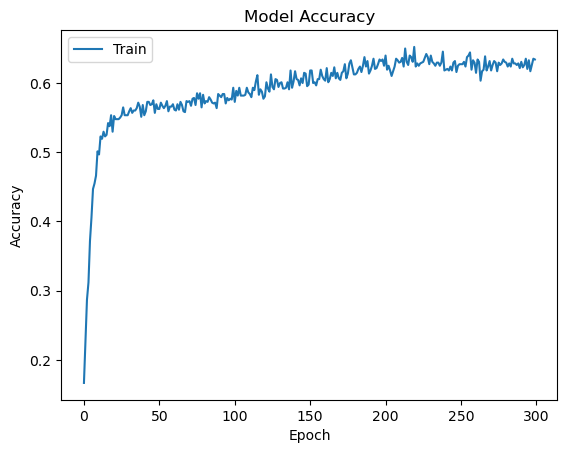

In [84]:
# Plot the accuracy
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
